## Youtube video :

https://www.youtube.com/watch?v=C0u_v7vEDBY

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def plot_data(x,y,colors):
    n_classes = len(np.unique(y))
    for i in range(n_classes):
        index = np.where(y == i)[0]
        plt.scatter(x[index,0],x[index,1],c=np.array(colors[i]))

## Let's make some data :

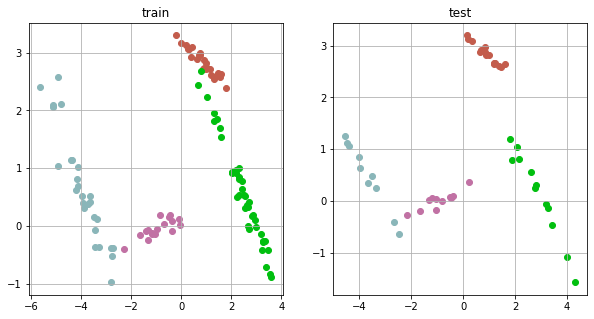

In [23]:
N_classes = 4
colors = np.random.uniform(0,1,(N_classes,1,3))
n = 150

X = np.empty((0,2))
y = np.empty((0))
for i in range(N_classes):
    n_samples_class = int(np.random.normal(n//N_classes,8))
    A = np.random.uniform(-1,1,((2,2)))
    COV = np.dot(A.T,A)
    mu = np.random.multivariate_normal(np.zeros(2),4*np.eye(2))
    x = np.random.multivariate_normal(mu,COV,n_samples_class)
    X = np.vstack((X,x))
    y = np.hstack((y,[i]*n_samples_class)).astype(int)

from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=.3,shuffle=True)

plt.figure(figsize=(10,5))
plt.subplot(121,title='train')
plt.grid()
plot_data(x_train,y_train, colors)

plt.subplot(122,title="test")
plt.grid()
plot_data(x_test,y_test, colors)

# QDA : Quadratic Discriminant Analysis :

In [24]:
class QDA_classifier :
    def __init__(self):
        self.densitys = []
        self.trained = False
        self.n_classes = None
        self.mu = []
        self.cov = []
        self.prior = []
        self.p = None
    
    def fit(self,x,y):
        self.n_classes = len(np.unique(y))
        n  = len(y)
        self.p = x.shape[1]
        
        for i in range(self.n_classes):
            index = np.where(y == i)[0]
            prior = len(index)/n
            mu_hat  = np.mean(x[index],axis = 0)
            cov_hat = np.dot(x[index].T,x[index]) /(len(index) - 1)
            self.prior.append(prior)
            self.mu.append(mu_hat)
            self.cov.append(cov_hat)
    
    def predict(self,X):
        predictions = []
        for x in X:
            scores = []
            for i in range(self.n_classes):
                score = self.prior[i] \
                * 1 / np.sqrt((2*np.pi)**self.p * np.linalg.det(self.cov[i]))\
                * np.exp(-1/2 * np.dot(  (x-self.mu[i]).T, np.dot(np.linalg.inv(self.cov[i]),x-self.mu[i]) ) ) 
                scores.append(score)
            predictions.append(np.argmax(scores))
        return np.array(predictions)
                
qda = QDA_classifier()
qda.fit(x_train,y_train)
pred = qda.predict(x_test)

## Evaluation :

accuracy : 0.9375


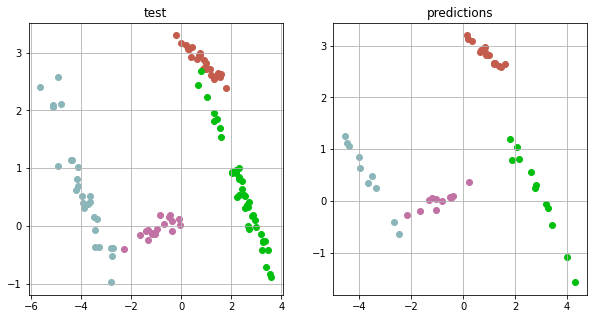

In [25]:
from sklearn.metrics import accuracy_score

plt.figure(figsize=(10,5))
plt.subplot(121,title="test")
plt.grid()
plot_data(x_train,y_train, colors)

plt.subplot(122,title="predictions")
plt.grid()
plot_data(x_test,y_test, colors)

print("accuracy :",accuracy_score(pred,y_test))

## Boudary decision line :

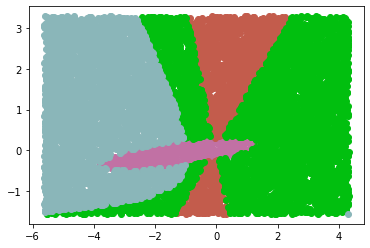

In [26]:
N = 10000
xx1 = np.random.uniform(X[:,0].min(),X[:,0].max(),(N,1))
xx2 = np.random.uniform(X[:,1].min(),X[:,1].max(),(N,1))
xx = np.hstack((xx1,xx2))
pred_xx = qda.predict(xx)

plot_data(xx,pred_xx,colors)

# LDA : Linear Discriminant Analysis

In [27]:
class LDA_classifier :
    def __init__(self):
        self.densitys = []
        self.trained = False
        self.n_classes = None
        self.mu = []
        self.cov = None
        self.prior = []
        self.p = None
    
    def fit(self,x,y):
        self.n_classes = len(np.unique(y))
        n  = len(y)
        self.p = x.shape[1]
        self.cov = np.zeros((self.p,self.p))
        for i in range(self.n_classes):
            index = np.where(y == i)[0]
            prior = len(index)/n
            mu_hat  = np.mean(x[index],axis = 0)
            self.cov += np.dot(x[index].T,x[index])
            self.prior.append(prior)
            self.mu.append(mu_hat)
        self.cov /= (n-self.n_classes)
    
    def predict(self,X):
        predictions = []
        for x in X:
            scores = []
            for i in range(self.n_classes):
                score = self.prior[i] \
                * 1 / np.sqrt((2*np.pi)**self.p * np.linalg.det(self.cov))\
                * np.exp(-1/2 * np.dot(  (x-self.mu[i]).T, np.dot(np.linalg.inv(self.cov),x-self.mu[i]) ) ) 
                scores.append(score)
            predictions.append(np.argmax(scores))
        return np.array(predictions)
                
lda = LDA_classifier()
lda.fit(x_train,y_train)
pred = qda.predict(x_test)

## Evaluation :

accuracy : 0.9375


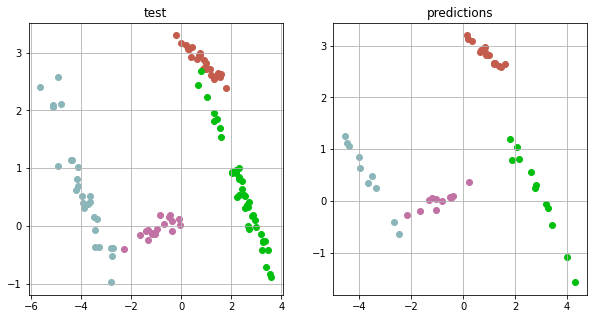

In [28]:
from sklearn.metrics import accuracy_score

plt.figure(figsize=(10,5))
plt.subplot(121,title="test")
plt.grid()
plot_data(x_train,y_train, colors)

plt.subplot(122,title="predictions")
plt.grid()
plot_data(x_test,y_test, colors)

print("accuracy :",accuracy_score(pred,y_test))

## Boudary decision line :

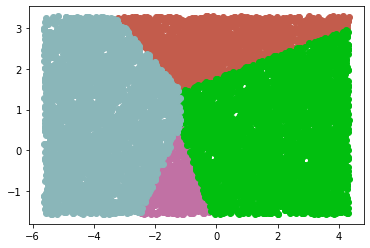

In [29]:
N = 10000
xx1 = np.random.uniform(X[:,0].min(),X[:,0].max(),(N,1))
xx2 = np.random.uniform(X[:,1].min(),X[:,1].max(),(N,1))
xx = np.hstack((xx1,xx2))
pred_xx = lda.predict(xx)

plot_data(xx,pred_xx,colors)

## Mixing QDA and LDA :

$\lambda = 0$ : pure QDA

$\lambda = 1$ : pure LDA

In [30]:
class LQDA_classifier :
    def __init__(self, Lambda):
        self.densitys = []
        self.trained = False
        self.n_classes = None
        self.mu = []
        self.cov = []
        self.cov_lda = None
        self.prior = []
        self.p = None
        self.Lambda = Lambda
    
    def fit(self,x,y):
        self.n_classes = len(np.unique(y))
        n  = len(y)
        self.p = x.shape[1]
        self.cov_lda = np.zeros((self.p,self.p))
        
        for i in range(self.n_classes):
            index = np.where(y == i)[0]
            prior = len(index)/n
            mu_hat  = np.mean(x[index],axis = 0)
            cov_hat = np.dot(x[index].T,x[index]) /(len(index) - 1)
            self.cov_lda += np.dot(x[index].T,x[index])
            self.prior.append(prior)
            self.mu.append(mu_hat)
            self.cov.append(cov_hat)
        self.cov_lda /= (n-self.n_classes)
    
    def predict(self,X):
        predictions = []
        for x in X:
            scores = []
            for i in range(self.n_classes):
                score = self.prior[i] \
                * 1 / np.sqrt((2*np.pi)**self.p * np.linalg.det((1-self.Lambda)*self.cov[i] + self.Lambda*self.cov_lda))\
                * np.exp(-1/2 * np.dot(  (x-self.mu[i]).T, np.dot(np.linalg.inv((1-self.Lambda)*self.cov[i] + self.Lambda*self.cov_lda),x-self.mu[i]) ) ) 
                scores.append(score)
            predictions.append(np.argmax(scores))
        return np.array(predictions)
                
lqda = LQDA_classifier(.5)
lqda.fit(x_train,y_train)
pred = lqda.predict(x_test)

## Choosing the best $\lambda$ :

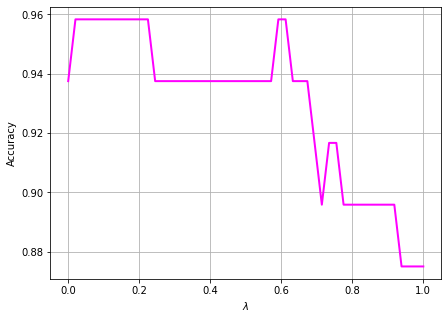

In [31]:
m = 50
Lambdas = np.linspace(0,1,m)
accuracys = np.zeros(m)

for i,Lambda in enumerate(Lambdas):
    lqda = LQDA_classifier(Lambda)
    lqda.fit(x_train,y_train)
    pred = lqda.predict(x_test)
    accuracys[i] = accuracy_score(pred,y_test)
    
plt.figure(figsize=(7,5))
plt.grid()
plt.plot(Lambdas,accuracys,linewidth=2,c='magenta')
plt.xlabel("$\lambda$")
plt.ylabel("Accuracy");

- > The best $\lambda$ really depends on the data itself.